# MNIST handwriting classification using <font color=red>softmax function</font>

# Index

1. Data

  1.1 Loading MNIST handwritten digits Data

  1.2 Data preprocessing

2. A model that linearly classifies using the Softmax function

3. Training

4. Test

Import python package

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.17.0


# [1] Data

## [1.1] Loading MNIST handwritten digits Data

In [ ]:
# from tensorflow.example.tutorials.mnist import input_data
# https://www.tensorflow.org/get_started/mnist/beginners
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_test shape: (10000, 28, 28), y_test shape: (10000,)


Check by visualizing data examples

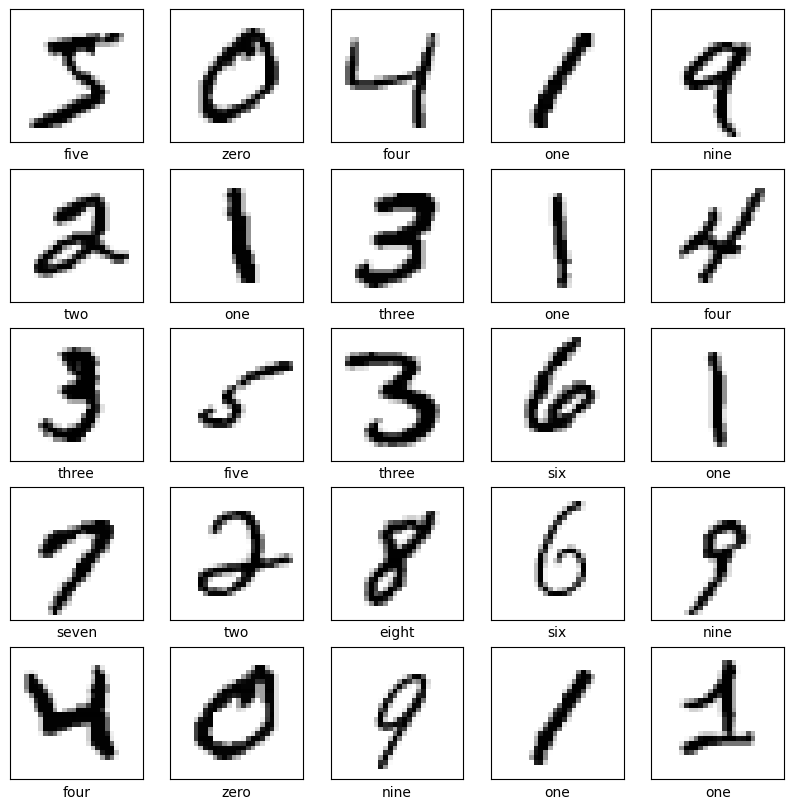

In [ ]:
class_names = ['zero', 'one', 'two', 'three', 'four', 'five',
               'six', 'seven', 'eight', 'nine']

# MNIST dataset parameters
num_classes = 10 # 0 to 9 digits
num_features = 784 # 28*28 = num_inputs, MNIST 손글씨는 28*28로 제공 됨

# plt
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(class_names[y_train[i]])
  plt.grid(False) # 이미지에 격자선 표시하지 않기
  plt.imshow(x_train[i], cmap=plt.cm.binary) # 흑백 이미지로 출력

## [1.2] Data preprocessing
- 딥러닝 프레임워크는 **float32** 형식을 사용하여 연산을 수행.
- 완전 연결된 신경망(fully connected layer)을 사용할 때는 입력(각 이미지)를 1차원 벡터로 변환.
- 0에서 1 사이의 정규화를 통해 신경망이 수렴 속도를 높이고 학습 안정성을 높이는 데 도움.

In [ ]:
# Convert to float32
x_train, y_train = np.array(x_train, np.float32), np.array(y_train, np.float32)
x_test, y_test = np.array(x_test, np.float32), np.array(y_test, np.float32)

# Flatten images to 1D vector of 784(28*28) features
# 28*28의 2D(2차원) 데이터 ->  784의 1D(1차원) 데이터로 펼친다
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Normalize images value from [0,255] to [0,1]
x_train, x_test = x_train / 255., x_test / 255.


x_train shape: (60000, 784), y_train shape: (60000,)
x_test shape: (10000, 784), y_test shape: (10000,)


# [2] A model that linearly classifies using the **Softmax function**

In [ ]:
tf.random.set_seed(1)
# Weight of shape [784, 10] = [image features, total number classes]
W = tf.Variable(tf.ones([num_features, num_classes]), name='weight')
# Bias of shape [10] = [total number of classes]
b = tf.Variable(tf.zeros([num_classes]), name='bias')

print(f'Weight shape: {W.shape}, Bias shape: {b.shape}')

Weight shape: (784, 10), Bias shape: (10,)


**Softmax function**
- 소프트맥스 함수는 다중 클래스 분류 문제에서 각 클래스에 속할 확률을 계산하는 데 사용.
- $x_{jk}$: $X_{k}$의 $j$번째 특징(feature) 값을 의미
- $W_{jk}$: 각각의 특징에 대한 가중치
- $b$: 편향(bias)
- $K$: 전체 클래스의 수

\begin{equation*}
z_k = W_{1k} \cdot x_{1k} + W_{2k} \cdot x_{2k} + \cdots + W_{pk} \cdot x_{pk} + b_k
\end{equation*}

\begin{equation*}
h(X_i)_k = \text{softmax}(z_k) = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}
\end{equation*}

**손실 함수(Cross entropy)**
- $L(W,b)$: 전체 데이터셋에 대한 평균 손실.
- $m$: 데이터셋의 총 샘플 수.
- $y_{\text{true}}^{(i, k)}$: 샘플 $i$가 클래스 $k$일 때의 실제 값(원-핫 인코딩)
- $h(X_i)_k$: 클래스 $i$가 $k$일 확률, 즉 소프트맥스 출력 값
\begin{equation*}
L(W, b) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_{\text{true}}^{(i, k)} \cdot \log(h(X_i)_k)
\end{equation*}

In [ ]:
# Softmax function
def softmax(x):
  z = tf.matmul(x, W) + b
  sm = tf.nn.softmax(z)
  return sm

# loss function(cross_entropy)
def cross_entropy(y_pred, y_true):
  # Encode label to a one hot vector
  y_true = tf.one_hot(y_true, depth=num_classes)
  # Clip prediction values to avoid log(0) error
  # log(0) 이면 loss_fn = int or nan 으로 나온다.
  y_pred = tf.clip_by_value(y_pred, 1e-9, 1.) # 하한, 상한
  # Compute cross-entropy
  loss = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))
  return loss

In [ ]:
# training parameters
learning_rate = 0.01 # Hyperparameter
training_steps = 1000
batch_size = 256
display_step = 100

# stochastic gradient descent algotithm to minimize loss function
optimizer = tf.optimizers.SGD(learning_rate)

In [ ]:
# Accuracy metric.
def accuracy(y_pred, y_true):
  # Predicted class is the index of the highest score in prediction vector (i.e. argmax).
  y_pred = tf.argmax(y_pred, axis=1)
  y_true = tf.cast(y_true, tf.int64)
  correct_prediction = tf.equal(y_pred, y_true)
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  return accuracy

In [ ]:
# Optimization process
def run_optimization(x, y):
  # Wrap computation inside a GradientTape for automatic differentiation
  with tf.GradientTape() as g:
    pred = softmax(x)
    loss = cross_entropy(pred, y)

  gradients = g.gradient(loss, [W, b])

  optimizer.apply_gradients(zip(gradients, [W, b]))

**Batch size에 따라 랜던하게 추출하여 묶기**

MNIST에서는 자동으로 제공되지만 직접 코딩 할 때

In [ ]:
n_train = x_train.shape[0]
n_test = x_test.shape[0]

def train_batch_maker(batch_size):
  idx = np.random.choice(n_train, batch_size) # 중복 추출
  return x_train[idx], y_train[idx]

def test_batch_maker(batch_size):
  idx = np.random.choice(n_test, batch_size) # 중복 추출
  return x_test[idx], y_test[idx]

# [3] Training

In [ ]:
# training
for step in range(training_steps):

  batch_x, batch_y = train_batch_maker(batch_size)

  # Run the optimization to update W and b values.
  run_optimization(batch_x, batch_y)

  if step % display_step == 0:
    pred = softmax(batch_x)
    loss = cross_entropy(pred, batch_y)
    acc = accuracy(pred, batch_y)
    print(f"step: {step}, loss: {loss}, accuracy: {acc}")

step: 0, loss: 2.2904725074768066, accuracy: 0.38671875
step: 100, loss: 1.5443241596221924, accuracy: 0.80859375
step: 200, loss: 1.2179697751998901, accuracy: 0.796875
step: 300, loss: 1.0299029350280762, accuracy: 0.82421875
step: 400, loss: 0.8676973581314087, accuracy: 0.84375
step: 500, loss: 0.7996860146522522, accuracy: 0.8515625
step: 600, loss: 0.7607371807098389, accuracy: 0.8359375
step: 700, loss: 0.7340826988220215, accuracy: 0.83203125
step: 800, loss: 0.7068673372268677, accuracy: 0.81640625
step: 900, loss: 0.5928139686584473, accuracy: 0.8671875


# [4] Test

In [ ]:
# Test model on validation set
pred = softmax(x_test)
print(f"Test Accuracy: {accuracy(pred, y_test)}")

Test Accuracy: 0.8712000250816345


Visualization

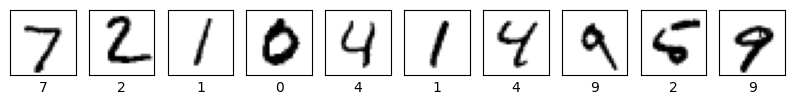

In [ ]:
n_images = 10
test_images = x_test[:n_images]
predictions = softmax(test_images)

# Display image and model prediction
plt.figure(figsize=(10, 10))
for i in range(n_images):
  plt.subplot(1, n_images, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(np.argmax(predictions[i])) # 가장 큰 값의 인덱스 출력
  plt.grid(False)
  plt.imshow(np.reshape(test_images[i], [28, 28]), cmap=plt.cm.binary)
plt.show()